### Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


In [3]:
# Imports 

# Imports para manipulação e visualização de dados
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Imports para manipulação de imagens
import os
import cv2
import itertools
import shutil
import imageio
import skimage
import skimage.io
import skimage.transform
from pathlib import Path

# Imports para Deep Learning
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.metrics import binary_accuracy

# Imports para cálculo de métricas e outras tarefas
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%matplotlib inline

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

sys       : 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
pandas    : 1.0.3
sklearn   : 1.0.2
numpy     : 1.18.5
cv2       : 4.5.5
keras     : 2.3.1
skimage   : 0.19.1
matplotlib: 3.3.4
tensorflow: 2.3.1
imageio   : 2.13.5



### DATASETS

### Definindo o Local de Armazenamento das Imagens de Raio-X

In [6]:
# Lista o conteúdo do diretório
os.listdir('/media/datasets')

['ChinaSet_AllFiles.zip',
 'ChinaSet_AllFiles',
 'NLM-MontgomeryCXRSet.zip',
 'MontgomerySet']

In [7]:
# Diretórios para os 2 grupos de imagens
imagens_shen = '/media/datasets/ChinaSet_AllFiles/CXR_png/'
imagens_mont = '/media/datasets/MontgomerySet/CXR_png/'

In [8]:
# Print do tamanho de cada pasta
print(len(os.listdir(imagens_shen)))
print(len(os.listdir(imagens_mont)))

663
139


In [9]:
# Grava a lista de imagens em cada pasta
shen_image_list = os.listdir(imagens_shen)
mont_image_list = os.listdir(imagens_mont)

### Preparando e Carregando as Imagens de Raio-X

In [10]:
# Prepara os dataframes com as listas das imagens
df_shen = pd.DataFrame(shen_image_list, columns = ['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns = ['image_id'])

In [11]:
# Remove da lista o nome 'Thumbs.db'
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

In [12]:
# Reset do índice para e evitar erros mais tarde
df_shen.reset_index(inplace = True, drop = True)
df_mont.reset_index(inplace = True, drop = True)

In [13]:
# Print do Shape
print(df_shen.shape)

(662, 1)


In [14]:
# Print do Shape
print(df_mont.shape)

(138, 1)


In [15]:
# Visualiza os dados
df_shen.head()

,image_id
0,CHNCXR_0501_1.png
1,CHNCXR_0223_0.png
2,CHNCXR_0051_0.png
3,CHNCXR_0179_0.png
4,CHNCXR_0621_1.png


In [16]:
# Visualiza os dados
df_mont.head()

,image_id
0,MCUCXR_0289_1.png
1,MCUCXR_0243_1.png
2,MCUCXR_0196_1.png
3,MCUCXR_0070_0.png
4,MCUCXR_0079_0.png


### Extraindo a Variável Target

In [17]:
# Função para selecionar o 4º índice no final da string (nome do arquivo)
# Exemplo: CHNCXR_0470_1.png --> 1 é o label, significa que Tuberculose está presente na imagem.

def extrair_target(x):
    
    target = int(x[-5])
    
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculose'

In [18]:
# Adicionando label aos dataframe
df_shen['target'] = df_shen['image_id'].apply(extrair_target)
df_mont['target'] = df_mont['image_id'].apply(extrair_target)

In [19]:
# Visualiza os dados
df_shen.head()

,image_id,target
0,CHNCXR_0501_1.png,Tuberculose
1,CHNCXR_0223_0.png,Normal
2,CHNCXR_0051_0.png,Normal
3,CHNCXR_0179_0.png,Normal
4,CHNCXR_0621_1.png,Tuberculose


In [20]:
# Visualiza os dados
df_mont.head()

,image_id,target
0,MCUCXR_0289_1.png,Tuberculose
1,MCUCXR_0243_1.png,Tuberculose
2,MCUCXR_0196_1.png,Tuberculose
3,MCUCXR_0070_0.png,Normal
4,MCUCXR_0079_0.png,Normal


In [21]:
# Shenzen Dataset
df_shen['target'].value_counts()

Tuberculose    336
Normal         326
Name: target, dtype: int64

In [22]:
# Montgomery Dataset
df_mont['target'].value_counts()

Normal         80
Tuberculose    58
Name: target, dtype: int64

### Visualizando as Imagens

In [23]:
# Função para visualizar as imagens
def visualiza_images(col_name, figure_cols, df, caminho_imagens):

    # Define as categorias
    categories = (df.groupby([col_name])[col_name].nunique()).index
    
    # Prepara os subplots
    f, ax = plt.subplots(nrows = len(categories), 
                         ncols = figure_cols, 
                         figsize = (4 * figure_cols, 4 * len(categories))) 
    
    # Desenha as imagens
    for i, cat in enumerate(categories):
        
        # Extrai uma amostra
        sample = df[df[col_name] == cat].sample(figure_cols) 
        
        # Loop pelas colunas da figura
        for j in range(0, figure_cols):
            
            # Extrai o nome da imagem
            file = caminho_imagens + sample.iloc[j]['image_id']
            
            # Lê a imagem do disco
            im = imageio.imread(file)
            
            # Mostra a imagem em gray (preto e branco)
            ax[i, j].imshow(im, resample = True, cmap = 'gray')
            ax[i, j].set_title(cat, fontsize = 14)  
            
    plt.tight_layout()
    plt.show()

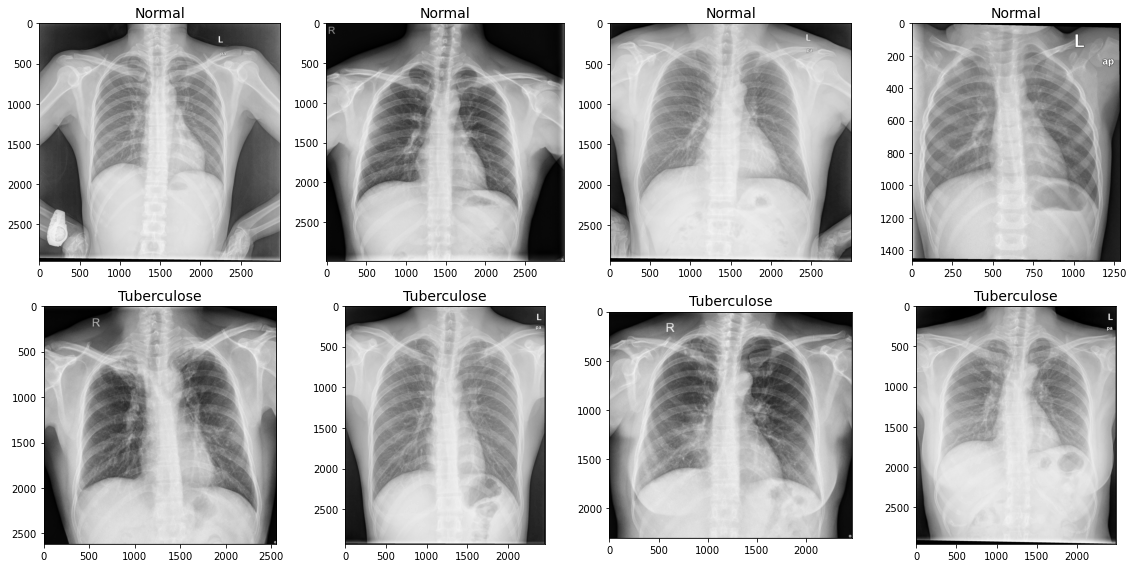

In [24]:
# Shenzen Dataset
visualiza_images('target', 4, df_shen, imagens_shen)

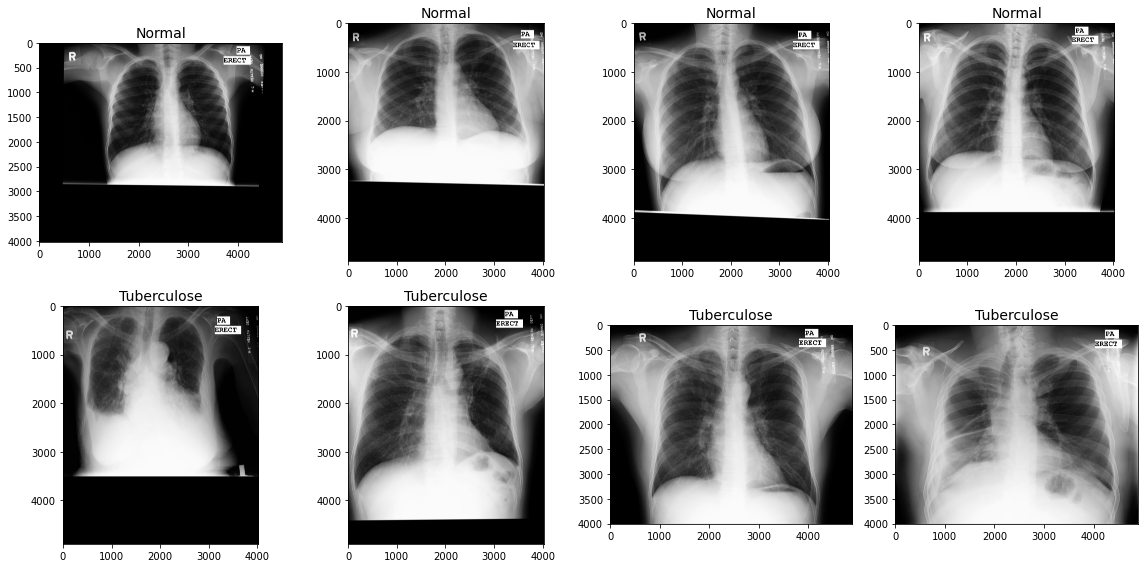

In [25]:
# Montgomery Dataset
visualiza_images('target', 4, df_mont, imagens_mont)

### Ajustando e Organizando o Primeiro Dataset de Imagens de Raio-X

In [26]:
# Função para leitura dos metadados das imagens
def leitura_imagens(file_name):

    # Leitura da imagem
    image = cv2.imread(caminho_imagens + file_name)
    
    # Extração do número máximo e mínimo de pixels
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[0] - largura da imagem 
    # image.shape[1] - altura da imagem 
    # image.shape[2] - número de canais
    # Se o shape não tiver um valor para num_channels (altura, largura) então atribuímos 1 ao número de canais.
    if len(image.shape) > 2: 
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [27]:
# Define o caminho onde estão as imagens
caminho_imagens = imagens_shen

In [28]:
# Retorna os metadados das imagens
meta_shen = np.stack(df_shen['image_id'].apply(leitura_imagens))

In [29]:
# Grava o resultado em um dataframe
df = pd.DataFrame(meta_shen, columns = ['largura', 'altura', 'canais', 'maior_valor_pixel', 'menor_valor_pixel'])

In [30]:
# Concatena com o dataset atual
df_shen = pd.concat([df_shen, df], axis = 1, sort = False)

In [31]:
# Shape
df_shen.shape

(662, 7)

In [32]:
# Visualiza
df_shen.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
0,CHNCXR_0501_1.png,Tuberculose,2906,2408,3,255,0
1,CHNCXR_0223_0.png,Normal,2939,3000,3,255,0
2,CHNCXR_0051_0.png,Normal,2935,2985,3,255,0
3,CHNCXR_0179_0.png,Normal,2941,3000,3,255,0
4,CHNCXR_0621_1.png,Tuberculose,2630,2584,3,255,0


In [33]:
# Não precisamos mais desse dataframe. Removemos para liberar espaço na memória RAM.
del df

### Ajustando e Organizando o Segundo Dataset de Imagens de Raio-X

In [34]:
# Define o caminho onde estão as imagens
caminho_imagens = imagens_mont

In [35]:
# Retorna os metadados das imagens
meta_mont = np.stack(df_mont['image_id'].apply(leitura_imagens))

In [36]:
# Grava o resultado em um dataframe
df = pd.DataFrame(meta_mont, columns = ['largura', 'altura', 'canais', 'maior_valor_pixel', 'menor_valor_pixel'])

In [37]:
# Concatena com o dataset atual
df_mont = pd.concat([df_mont, df], axis = 1, sort = False)

In [38]:
# Visualiza
df_mont.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
0,MCUCXR_0289_1.png,Tuberculose,4892,4020,3,255,0
1,MCUCXR_0243_1.png,Tuberculose,4020,4892,3,255,0
2,MCUCXR_0196_1.png,Tuberculose,4892,4020,3,255,0
3,MCUCXR_0070_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0079_0.png,Normal,4020,4892,3,255,0


In [39]:
# Não precisamos mais desse dataframe. Removemos para liberar espaço na memória RAM.
del df

### Divisão dos Dados em Treino, Validação e Teste

In [40]:
# Total de registros
df_shen['target'].value_counts()

Tuberculose    336
Normal         326
Name: target, dtype: int64

In [41]:
# Total de registros
df_mont['target'].value_counts()

Normal         80
Tuberculose    58
Name: target, dtype: int64

In [42]:
# Vamos combinar os 2 dataframes 
df_data = pd.concat([df_shen, df_mont], axis = 0).reset_index(drop = True)

In [43]:
# E "embaralhar (shuffle)" os dados
df_data = shuffle(df_data)

In [44]:
# Shape
df_data.shape

(800, 7)

In [45]:
# Visualiza os dados
df_data.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
474,CHNCXR_0115_0.png,Normal,1149,1225,3,255,0
207,CHNCXR_0559_1.png,Tuberculose,2883,2735,3,255,0
316,CHNCXR_0013_0.png,Normal,2937,3000,3,255,0
519,CHNCXR_0657_1.png,Tuberculose,2977,2738,3,255,0
601,CHNCXR_0184_0.png,Normal,2947,3000,3,255,0


In [46]:
# Cria uma nova coluna chamada 'labels' que mapeia as classes para valores binários (0 ou 1)
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculose':1})

In [47]:
# Visualiza os dados
df_data.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel,labels
474,CHNCXR_0115_0.png,Normal,1149,1225,3,255,0,0
207,CHNCXR_0559_1.png,Tuberculose,2883,2735,3,255,0,1
316,CHNCXR_0013_0.png,Normal,2937,3000,3,255,0,0
519,CHNCXR_0657_1.png,Tuberculose,2977,2738,3,255,0,1
601,CHNCXR_0184_0.png,Normal,2947,3000,3,255,0,0


In [48]:
# Definimos y (saída)
y = df_data['labels']

In [49]:
# Definimos dados de treino e validação
df_treino, df_val = train_test_split(df_data, test_size = 0.15, random_state = 101, stratify = y)

In [54]:
# Definimos a saída para o novo conjunto de treino
x = df_treino['labels']

In [55]:
# Nova divisão
# Agora definimos dados de treino e teste
df_treino, df_test = train_test_split(df_treino, test_size = 0.15, random_state = 101, stratify = x)

In [56]:
# Print
print(df_treino.shape)
print(df_val.shape)
print(df_test.shape)

(578, 8)
(120, 8)
(102, 8)


In [57]:
# Total de registros
df_treino['target'].value_counts()

Normal         293
Tuberculose    285
Name: target, dtype: int64

In [58]:
# Total de registros
df_val['target'].value_counts()

Normal         61
Tuberculose    59
Name: target, dtype: int64

In [59]:
# Total de registros
df_test['target'].value_counts()

Normal         52
Tuberculose    50
Name: target, dtype: int64

### Separando as Imagens Organizadas Por Classe

In [60]:
# Cria um novo diretório que servirá como base
base_dir = 'dataset/'

# Criamos o PATH (caminho)
dir_base = Path(base_dir)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_base.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(base_dir)

Criaremos as pastas abaixo no diretório base:

- dados_treino/
    - Normal
    - Tuberculose
    
    
- dados_val/
    - Normal
    - Tuberculose
    
    
- dados_test/
    - Normal
    - Tuberculose

### Criação do diretório com dados de treino

In [62]:
# Preparamos a criação do diretório com dados de treino
dados_treino = os.path.join(base_dir, 'dados_treino/')

# Criamos o PATH (caminho)
dir_treino = Path(dados_treino)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(dados_treino)

In [63]:
# Diretório para imagens de raio-x Normais para treinamento
Normal = os.path.join(dados_treino, 'Normal')

# Criamos o PATH (caminho)
dir_normal_treino = Path(Normal)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_normal_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [64]:
# Diretório com imagens de raio-x com Tuberculose para treinamento
Tuberculose = os.path.join(dados_treino, 'Tuberculose')

# Criamos o PATH (caminho)
dir_tb_treino = Path(Tuberculose)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_tb_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

### Criação do diretório com dados de validação

In [65]:
# Preparamos a criação do diretório com dados de validação
dados_val = os.path.join(base_dir, 'dados_val/')

# Criamos o PATH (caminho)
dir_val = Path(dados_val)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(dados_val)

In [66]:
# Diretório com imagens de raio-x Normais para validação
Normal = os.path.join(dados_val, 'Normal')

# Criamos o PATH (caminho)
dir_normal_val = Path(Normal)

# Verificamos se o diretório já existe
if dir_normal_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [67]:
# Diretório com imagens de raio-x com Tuberculose para validação
Tuberculose = os.path.join(dados_val, 'Tuberculose')

# Criamos o PATH (caminho)
dir_tb_val = Path(Tuberculose)

# Verificamos se o diretório já existe
if dir_tb_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

### Criação do diretório com dados de teste

In [68]:
# Preparamos a criação do diretório com dados de teste
dados_test = os.path.join(base_dir, 'dados_test/')

# Criamos o PATH (caminho)
dir_test = Path(dados_test)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_test.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(dados_test)

In [69]:
# Diretório com imagens de raio-x Normais para teste
Normal = os.path.join(dados_test, 'Normal')

# Criamos o PATH (caminho)
dir_normal_test = Path(Normal)

# Verificamos se o diretório já existe
if dir_normal_test.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [70]:
# Diretório com imagens de raio-x com Tuberculose para teste
Tuberculose = os.path.join(dados_test, 'Tuberculose')

# Criamos o PATH (caminho)
dir_tb_test = Path(Tuberculose)

# Verificamos se o diretório já existe
if dir_tb_test.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

### Ajustes

In [71]:
# Define o image_id como o índice em df_data
df_data.set_index('image_id', inplace = True)

In [72]:
# Checamos df_data
df_data.head()

,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel,labels
image_id,,,,,,,
CHNCXR_0115_0.png,Normal,1149,1225,3,255,0,0
CHNCXR_0559_1.png,Tuberculose,2883,2735,3,255,0,1
CHNCXR_0013_0.png,Normal,2937,3000,3,255,0,0
CHNCXR_0657_1.png,Tuberculose,2977,2738,3,255,0,1
CHNCXR_0184_0.png,Normal,2947,3000,3,255,0,0


In [73]:
# Obtém uma lista de imagens em cada uma das duas pastas originais
folder_1 = os.listdir(imagens_shen)
folder_2 = os.listdir(imagens_mont)

In [74]:
folder_1[1:10]

['CHNCXR_0223_0.png',
 'CHNCXR_0051_0.png',
 'CHNCXR_0179_0.png',
 'CHNCXR_0621_1.png',
 'CHNCXR_0201_0.png',
 'CHNCXR_0656_1.png',
 'CHNCXR_0535_1.png',
 'CHNCXR_0425_1.png',
 'CHNCXR_0199_0.png']

In [75]:
folder_2[1:10]

['MCUCXR_0243_1.png',
 'MCUCXR_0196_1.png',
 'MCUCXR_0070_0.png',
 'MCUCXR_0079_0.png',
 'MCUCXR_0046_0.png',
 'MCUCXR_0047_0.png',
 'MCUCXR_0228_1.png',
 'MCUCXR_0390_1.png',
 'MCUCXR_0173_1.png']

In [76]:
# Obtém uma lista de imagens de treino, validação e teste
lista_imagens_treino = list(df_treino['image_id'])
lista_imagens_val = list(df_val['image_id'])
lista_imagens_test = list(df_test['image_id'])

In [77]:
lista_imagens_treino[20:30]

['CHNCXR_0192_0.png',
 'CHNCXR_0476_1.png',
 'CHNCXR_0533_1.png',
 'MCUCXR_0090_0.png',
 'CHNCXR_0014_0.png',
 'CHNCXR_0594_1.png',
 'CHNCXR_0549_1.png',
 'CHNCXR_0277_0.png',
 'CHNCXR_0304_0.png',
 'CHNCXR_0574_1.png']

In [78]:
lista_imagens_val[10:20]

['CHNCXR_0344_1.png',
 'CHNCXR_0200_0.png',
 'CHNCXR_0635_1.png',
 'CHNCXR_0025_0.png',
 'CHNCXR_0424_1.png',
 'CHNCXR_0056_0.png',
 'CHNCXR_0420_1.png',
 'CHNCXR_0072_0.png',
 'CHNCXR_0599_1.png',
 'CHNCXR_0404_1.png']

In [79]:
lista_imagens_test[0:10]

['CHNCXR_0606_1.png',
 'MCUCXR_0026_0.png',
 'CHNCXR_0123_0.png',
 'CHNCXR_0490_1.png',
 'CHNCXR_0595_1.png',
 'CHNCXR_0528_1.png',
 'CHNCXR_0027_0.png',
 'MCUCXR_0228_1.png',
 'CHNCXR_0297_0.png',
 'CHNCXR_0254_0.png']

### Pré-Processamento das Imagens

In [80]:
# Resize das imagens
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

Agora copiamos as imagens separadas por classe, redimensionamos e organizamos no novo diretório.

### Imagens de treino

In [81]:
# Transfere as imagens de treino pré-processadas para o novo diretório

print('\nPré-processamento dos dados de treino! Aguarde...')

# Loop pela lista de imagens de treino
for image in lista_imagens_treino:
    
    # Nome da imagem
    fname = image
    
    # Label da imagem
    label = df_data.loc[image,'target']
    
    # Percorremos a folder_1 (imagens do dataset de shenzen) para buscar o caminho da imagem
    if fname in folder_1:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_shen, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_treino, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

    # Percorremos a folder_2 (imagens do dataset de montgomery) para buscar o caminho da imagem
    if fname in folder_2:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_mont, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_treino, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

print('\nOs dados de treino estão prontos!')


Pré-processamento dos dados de treino! Aguarde...

Os dados de treino estão prontos!


### Imagens de Validação

In [83]:
# Transfere as imagens de validação pré-processadas para o novo diretório

print('\nPré-processamento dos dados de valiação! Aguarde...')

# Loop pela lista de imagens de validação/teste
for image in lista_imagens_val:
    
    # Nome da imagem
    fname = image
    
    # Label da imagem
    label = df_data.loc[image,'target']
    
    # Percorremos a folder_1 (imagens do dataset de shenzen) para buscar o caminho da imagem
    if fname in folder_1:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_shen, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_val, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

    # Percorremos a folder_2 (imagens do dataset de montgomery) para buscar o caminho da imagem
    if fname in folder_2:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_mont, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_val, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)
        
print('\nOs dados de validação estão prontos!')


Pré-processamento dos dados de valiação! Aguarde...

Os dados de validação estão prontos!


### Imagens de teste

In [84]:
# Transfere as imagens de teste pré-processadas para o novo diretório

print('\nPré-processamento dos dados de teste! Aguarde...')

# Loop pela lista de imagens de teste
for image in lista_imagens_test:
    
    # Nome da imagem
    fname = image
    
    # Label da imagem
    label = df_data.loc[image,'target']
    
    # Percorremos a folder_1 (imagens do dataset de shenzen) para buscar o caminho da imagem
    if fname in folder_1:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_shen, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_test, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

    # Percorremos a folder_2 (imagens do dataset de montgomery) para buscar o caminho da imagem
    if fname in folder_2:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_mont, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_test, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)
        
print('\nOs dados de teste estão prontos!')


Pré-processamento dos dados de teste! Aguarde...

Os dados de teste estão prontos!


### Verificação da quantida de imagens nos diretórios

In [85]:
# Verificamos quantas imagens de treino temos em cada pasta de classe
print(len(os.listdir(dados_treino + '/Normal')))
print(len(os.listdir(dados_treino + '/Tuberculose')))

293
285


In [86]:
# Verificamos quantas imagens de validação temos em cada pasta de classe
print(len(os.listdir(dados_val + '/Normal')))
print(len(os.listdir(dados_val + '/Tuberculose')))

61
59


In [87]:
# Verificamos quantas imagens de teste temos em cada pasta de classe
print(len(os.listdir(dados_test + '/Normal')))
print(len(os.listdir(dados_test + '/Tuberculose')))

52
50


### Dataset Augmentation (Geração de Imagens Sintéticas)

In [88]:
# Lista de classes
class_list = ['Normal', 'Tuberculose']

In [89]:
# Número de imagens sintéticas desejadas
NUM_IMAGENS_SINTETICAS = 1000 

In [90]:
# Cria imagens sintéticas para aumentar o volume de dados de treino (não faremos isso com dados de validação/teste)

print('\nGeração de imagens sintéticas para treinamento! Aguarde...\n')

# Loop pelas imagens de cada classe
for item in class_list:
    
    # Estamos criando diretório temporário aqui porque o excluiremos posteriormente.
    # Criamos um diretório base
    aug_dir = base_dir + 'temp/'
    os.mkdir(aug_dir)
    
    # Criamos um diretório dentro do diretório base para armazenar imagens da mesma classe
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Escolhe a classe
    img_class = item

    # Listamos todas as imagens no diretório
    img_list = os.listdir(dados_treino + img_class)

    # Copiamos imagens do diretório de treino para a classe no loop, para o img_dir
    for fname in img_list:
            
            # Diretório fonte da imagem
            src = os.path.join(dados_treino + img_class, fname)
            
            # Diretório destino da imagem
            dst = os.path.join(img_dir, fname)
            
            # Copia a imagem da fonte para o destino
            shutil.copyfile(src, dst)


    # Apontamos para o diretório contendo as imagens que foram copiadas
    path = aug_dir
    save_path = dados_treino + img_class

    # Criamos um gerador de imagens 
    datagen = ImageDataGenerator(rotation_range = 10,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 zoom_range = 0.1,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest')

    # Tamanho do batch
    batch_size = 50

    # Geração de dados
    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir = save_path,
                                              save_format = 'png',
                                              target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                              batch_size = batch_size)
    
    
    # Geramos as imagens aumentadas e adicionamos às pastas de treinamento
    num_files = len(os.listdir(img_dir))
    
    # Aqui criamos uma quantidade semelhante de imagens para cada classe
    num_batches = int(np.ceil((NUM_IMAGENS_SINTETICAS - num_files) / batch_size))

    # Executa o gerador e cria imagens aumentadas
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)
        
    # Exclui o diretório temporário com os arquivos de imagem brutos
    shutil.rmtree(aug_dir)
    
print('\nOs dados foram criados com sucesso!')


Geração de imagens sintéticas para treinamento! Aguarde...

Found 293 images belonging to 1 classes.
Found 285 images belonging to 1 classes.

Os dados foram criados com sucesso!


In [91]:
# Verificamos quantas imagens de treino temos agora em cada pasta.
# Estas são as imagens originais mais as imagens sintéticas.
print(len(os.listdir(dados_treino + 'Normal')))
print(len(os.listdir(dados_treino + 'Tuberculose')))

1029
1005


In [92]:
# Verifica quantas imagens de validação temos em cada pasta (deve ser o mesmo número inicial)
# Estas são as imagens originais mais as imagens sintéticas.
print(len(os.listdir(dados_val + 'Normal')))
print(len(os.listdir(dados_val + 'Tuberculose')))

61
59


In [93]:
# Verifica quantas imagens de teste temos em cada pasta (deve ser o mesmo número inicial)
# Estas são as imagens originais mais as imagens sintéticas.
print(len(os.listdir(dados_test + 'Normal')))
print(len(os.listdir(dados_test + 'Tuberculose')))

52
50


### Visualização (Imagens sintéticas)

In [94]:
# Função para o plot de algumas imagens
def plots(ims, figsize = (20,10), rows = 5, interp = False, titles = None): 
    
    # Obtém a imagem
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    
    # Define o tamanho da figura
    f = plt.figure(figsize = figsize)
    
    # Colunas
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    # Plot
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

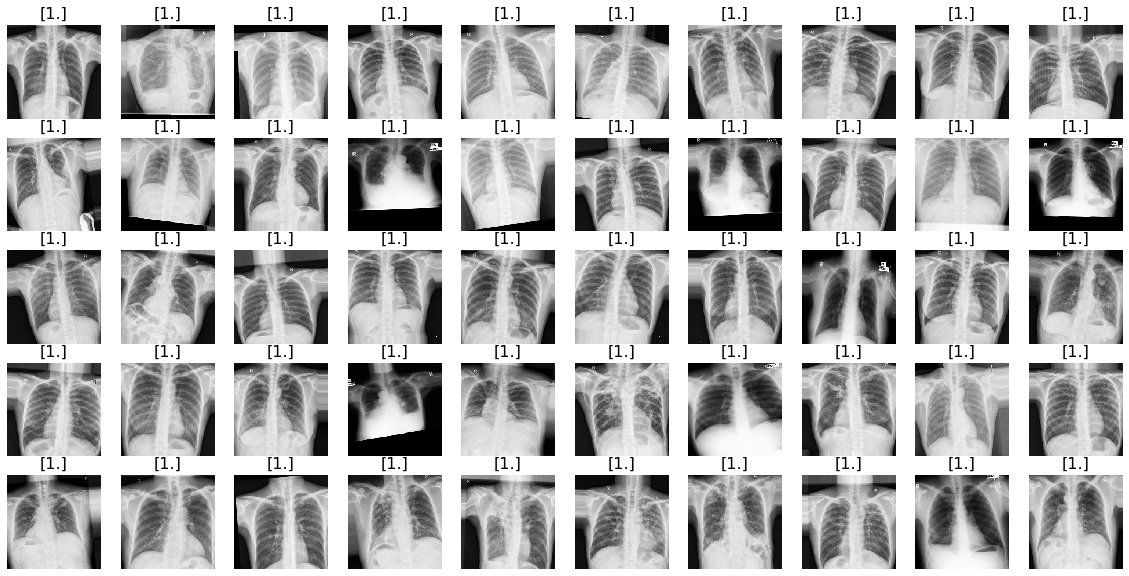

In [95]:
# Executa a função
plots(imgs, titles = labels) 